# Calculate and plot the ratio of nonphaselocked to phaselocked internal tides

In [16]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map
import numpy as np

from dask.diagnostics import ProgressBar

In [2]:
# s3login = '/home/mrayson/code/s3.acacia.login'
s3login = '/home/jupyter-mrayson/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)


In [44]:
s3.ls('uwaoceanprocesses-suntans/')

['uwaoceanprocesses-suntans/.zattrs',
 'uwaoceanprocesses-suntans/.zgroup',
 'uwaoceanprocesses-suntans/.zmetadata',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_eta_seasonaltides.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered_astrotides.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered_seasonaltides.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered_spacechunk.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered_astrotides.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered_seasonal.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered_seasonaltides.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014

In [88]:

# invarname = 'eta'
# invarname = 'vc'
invarname = 'uc'

# zarrin = 'NWS_2km_GLORYS_2013_2014_{}_seasonaltides.zarr'.format(invarname)
zarrin = f'NWS_2km_GLORYS_2013_2014_{invarname}_filtered_seasonaltides.zarr'
# zarrin = 'NWS_2km_GLORYS_2013_2014_uc_filtered_seasonaltides.zarr'

varname = '{}_non_phase_locked'.format(invarname)

##
f = S3Map("uwaoceanprocesses-suntans/"+zarrin, s3=s3)

ds = xr.open_dataset(f, engine='zarr', chunks={})

# These need filling in??
ds.suntans.xv=ds.xv.values
ds.suntans.yv=ds.yv.values

ds

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:              (Nc: 225368, numsides: 8, Nk: 80, time: 8761,
                          Np: 454016)
Coordinates:
  * time                 (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-0...
    z_r                  (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells                (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    dz                   (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    nfaces               (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
    uc_non_phase_locked  (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    uc_phase_locked      (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    xp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [98]:
%%time
vc_pl_var = ds[f'{invarname}_phase_locked'].var(axis=0)
with ProgressBar():
    vc_pl_var = vc_pl_var.compute()

[########################################] | 100% Completed | 33.71 s
CPU times: user 39.9 s, sys: 20.1 s, total: 1min
Wall time: 33.7 s


In [99]:
%%time
# Don't need this because it contains all of the mesoscale variance
vc_npl_var2 = ds[f'{invarname}_non_phase_locked'].var(axis=0)
with ProgressBar():
    vc_npl_var2 = vc_npl_var.compute()

CPU times: user 2.8 ms, sys: 0 ns, total: 2.8 ms
Wall time: 2.76 ms


In [100]:
paramsfile = '../DATA/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_fD2D1_vc.nc'
ds_params = xr.open_dataset(paramsfile, engine='h5netcdf')
ds_params.suntans.xv=ds_params.xv.values
ds_params.suntans.yv=ds_params.yv.values

ds_params

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:    (Nc: 225368, numsides: 8, params: 9, Nk: 80, time: 8761,
                Np: 454016)
Coordinates:
  * time       (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r        (Nk) float64 ...
Dimensions without coordinates: Nc, numsides, params, Nk, Np
Data variables:
    cells      (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    data       (Nc, params) float64 ...
    dv         (Nc) float64 ...
    dz         (Nk) float64 ...
    f_cpd_inv  (Nc) float32 ...
    nfaces     (Nc) int32 6 6 6 6 6 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6 6 6 6 6 6
    xp         (Np) float64 125.2 114.2 136.3 125.4 ... 117.0 117.0 117.1 117.1
    xv         (Nc) float64 109.0 109.1 109.1 109.2 ... 117.7 117.7 117.7 117.9
    yp         (Np) float64 -14.48 -22.48 -13.24 -14.54 ... -18.27 -18.27 -18.26
    yv         (Nc) float64 -19.4 -19.5 -19.61 -19.71 ... -13.1 -13.12 -13.07
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [101]:
idx = [5,7]

# D2
vc_npl_var = ds_params['data'].isel(params=idx[0]) **2.\
    + ds_params['data'].isel(params=idx[1]) **2.

In [102]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'

# Regional plots
def plot_contours(ds, clevs=[200,1000]):
    return ds.suntans.contourf(ds.dv, clevs, 
                           colors='k', 
                           linewidths=0.5, 
                           filled=False, colorbar=False)


def add_colorbar(ax, cc, vmin, vmax, titlestr):
    font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 12,
        }
    #cbaxes = inset_axes(ax, width="30%", height="3%", loc='lower right', bbox_to_anchor=(0, 0.1, 1, 1),
    #                       bbox_transform=ax.transAxes)
    #cb=plt.colorbar(cc, orientation='horizontal', cax=cbaxes)
    cb=plt.colorbar(cc, ax=ax, orientation='horizontal', shrink=0.3, pad=-0.1, )

    cb.set_ticks([vmin,vmax])
    cb.ax.set_title(titlestr, fontdict=font)

    return cb
    

Text(0, 0.5, 'Latitude [$^{\\circ}$N]')

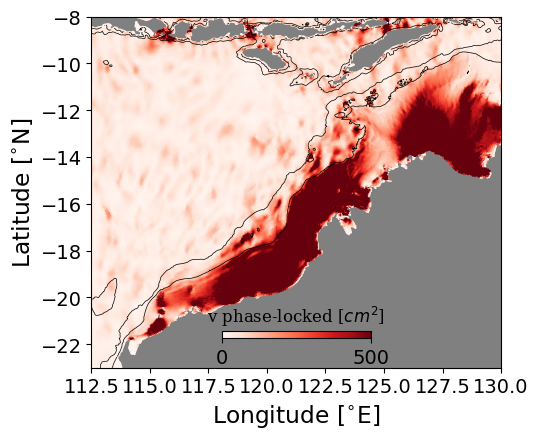

In [103]:
vmax = 0.05*1e4
xlim = 112.5, 130
ylim = -23, -8
units='$cm^2$'
###

plt.figure()
ax1=plt.subplot(111, facecolor='0.5')
_,_,cc,_ = ds.suntans.plotcelldata(vc_pl_var*1e4, 
                                          cmap='Reds', vmin=0,vmax=vmax, colorbar=False)
plot_contours(ds)
add_colorbar(ax1, cc, 0, vmax, r'v phase-locked [{}]'.format(units))
#plt.title('Incoherent f amplitude [{}]'.format(units))
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
#ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]')  


Text(0, 0.5, 'Latitude [$^{\\circ}$N]')

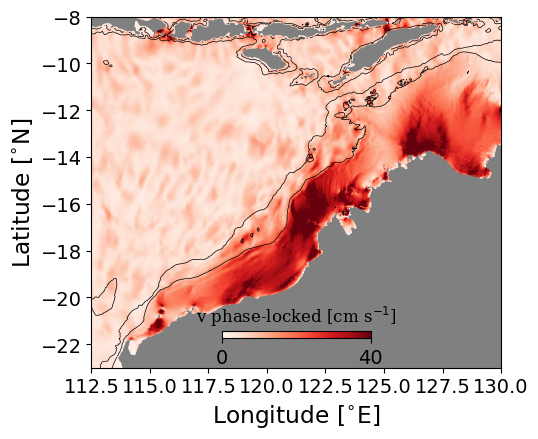

In [104]:
vmax = 40
xlim = 112.5, 130
ylim = -23, -8
units='cm s$^{-1}$'
###

plt.figure()
ax1=plt.subplot(111, facecolor='0.5')
_,_,cc,_ = ds.suntans.plotcelldata(np.sqrt(vc_pl_var)*1e2, 
                                          cmap='Reds', vmin=0,vmax=vmax, colorbar=False)
plot_contours(ds)
add_colorbar(ax1, cc, 0, vmax, r'v phase-locked [{}]'.format(units))
#plt.title('Incoherent f amplitude [{}]'.format(units))
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
#ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]')  


Text(0, 0.5, 'Latitude [$^{\\circ}$N]')

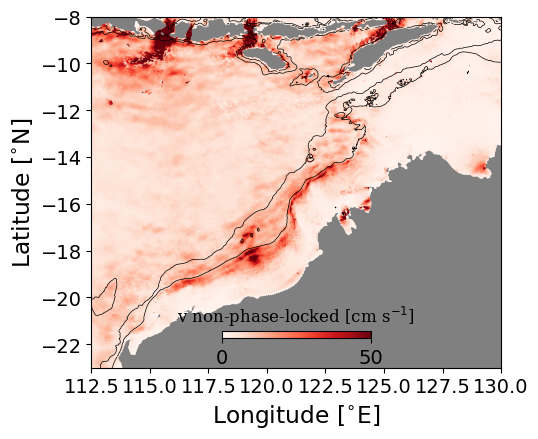

In [105]:
# Derived from covariance parameters
vmax = 0.005*1e4
plt.figure()
ax1=plt.subplot(111, facecolor='0.5')
_,_,cc,_ = ds.suntans.plotcelldata(vc_npl_var*1e4, 
                                          cmap='Reds', vmin=0,vmax=vmax, colorbar=False)
plot_contours(ds)
add_colorbar(ax1, cc, 0, vmax, r'v non-phase-locked [{}]'.format(units))
#plt.title('Incoherent f amplitude [{}]'.format(units))
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
#ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]')  

Text(0, 0.5, 'Latitude [$^{\\circ}$N]')

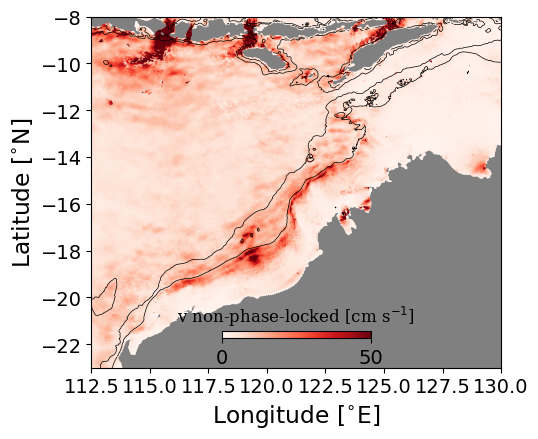

In [106]:
# Derived from filtered time-series
vmax = 0.005*1e4
plt.figure()
ax1=plt.subplot(111, facecolor='0.5')
_,_,cc,_ = ds.suntans.plotcelldata(vc_npl_var2*1e4, 
                                          cmap='Reds', vmin=0,vmax=vmax, colorbar=False)
plot_contours(ds)
add_colorbar(ax1, cc, 0, vmax, r'v non-phase-locked [{}]'.format(units))
#plt.title('Incoherent f amplitude [{}]'.format(units))
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
#ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]')  

Text(0, 0.5, 'Latitude [$^{\\circ}$N]')

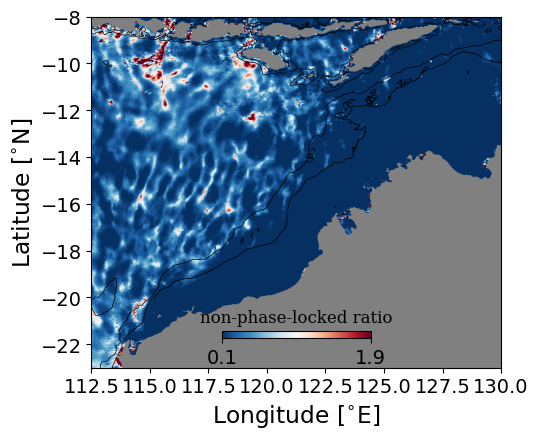

In [108]:
ratio = vc_npl_var2/vc_pl_var
vmin=0.1
vmax=1.9
plt.figure()
ax1=plt.subplot(111, facecolor='0.5')
_,_,cc,_ = ds.suntans.plotcelldata(ratio, 
                                          cmap='RdBu_r', vmin=vmin,vmax=vmax, colorbar=False)
plot_contours(ds)
add_colorbar(ax1, cc, vmin, vmax, r'non-phase-locked ratio'.format(units))
#plt.title('Incoherent f amplitude [{}]'.format(units))
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
#ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]')  

Text(0, 0.5, 'Latitude [$^{\\circ}$N]')

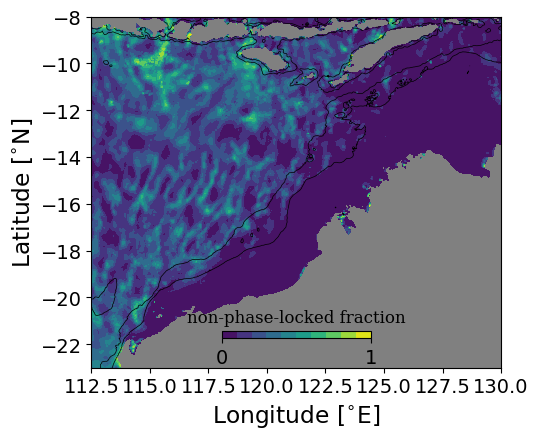

In [109]:
ratio2 = vc_npl_var2/(vc_npl_var2+vc_pl_var)
ratio2[np.isnan(ratio2)] = 0.

units = ''
vmin=0.0
vmax=1.0
plt.figure()
ax1=plt.subplot(111, facecolor='0.5')
# _,_,cc,_ = ds.suntans.plotcelldata(ratio2, 
                                          # cmap='viridis', vmin=vmin,vmax=vmax, colorbar=False)
_,_,cc,_ = ds.suntans.contourf(ratio2, np.arange(0,1.1,0.1),
                                          cmap='viridis', vmin=vmin,vmax=vmax, colorbar=False)
plot_contours(ds)
add_colorbar(ax1, cc, vmin, vmax, r'non-phase-locked fraction')
#plt.title('Incoherent f amplitude [{}]'.format(units))
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
#ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]')  

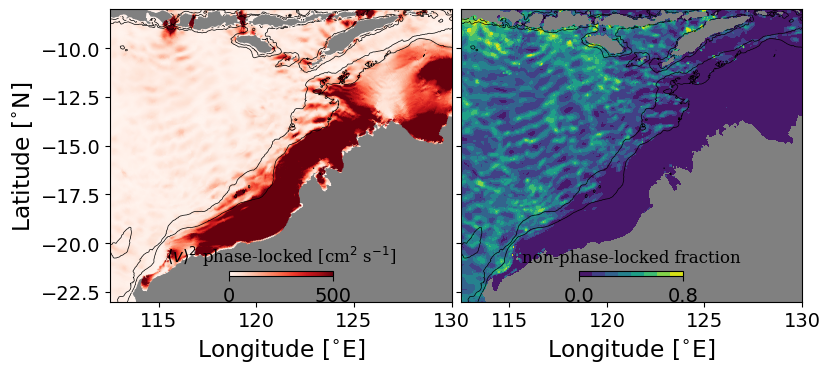

In [87]:
vmax = 0.05*1e4
xlim = 112.5, 130
ylim = -23, -8
# units='$cm^2$'
units='cm$^2$ s$^{-1}$'

###

plt.figure(figsize=(9,4))

ax1=plt.subplot(121, facecolor='0.5')
_,_,cc,_ = ds.suntans.plotcelldata(vc_pl_var*1e4, 
                                          cmap='Reds', vmin=0,vmax=vmax, colorbar=False)
plot_contours(ds)
add_colorbar(ax1, cc, 0, vmax, r'$\left<v\right>^2$ phase-locked [{}]'.format(units))
#plt.title('Incoherent f amplitude [{}]'.format(units))
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
#ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]')  

###
units = ''
vmin=0.0
vmax=0.8
ax2=plt.subplot(122, facecolor='0.5')
# _,_,cc,_ = ds.suntans.plotcelldata(ratio2, 
                                          # cmap='viridis', vmin=vmin,vmax=vmax, colorbar=False)
_,_,cc,_ = ds.suntans.contourf(ratio2, np.arange(0,vmax+0.1,0.1),
                                          cmap='viridis', vmin=vmin,vmax=vmax, colorbar=False)
plot_contours(ds)
add_colorbar(ax2, cc, vmin, vmax, r'non-phase-locked fraction')
#plt.title('Incoherent f amplitude [{}]'.format(units))
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
#ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
ax2.set_yticklabels([])
#plt.tight_layout()
plt.subplots_adjust(wspace=0.01)
# plt.ylabel('Latitude [$^{\circ}$N]')  
plt.savefig('../FIGURES/non_phase_locked_ratio_NWS.png',dpi=150)

# Browse basin plots

In [110]:
sites = {
'NIN100':{'y':-21.84986667,'x':113.9064667},
'NWSBAR':{'y':-20.76128333,'x':114.7586167},
'NWSROW':{'y':-17.75801667,'x':119.9061},
'NWSBRW':{'y':-14.23543333,'x':123.1623833},
'NWSLYN':{'y':-9.939416667,'x':130.3490833},
'PIL200':{'x': 115.9154, 'y':-19.435333}   ,
'KIM200':{'x':121.243217 , 'y':-15.534517} ,  
'KIM400':{'x': 121.114967, 'y':-15.22125}   ,
'ITFTIS':{'x': 127.5577, 'y':-9.819217}   ,
'BB250':{'x':123.34613 , 'y':-13.75897}  ,
'Prelude':{'x':123.3506, 'y':-13.7641} , 
'INPEX_buoy':{'x':123.26434722222223, 'y':-13.929844444444445} , 
}

def plot_site(name, ax):
    ax.plot(sites[name]['x'], sites[name]['y'], 'ro', markeredgecolor='k')


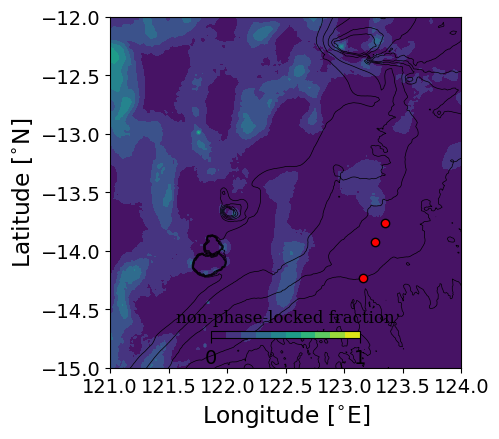

In [111]:
ax1=plt.subplot(111, facecolor='0.5')
# _,_,cc,_ = ds.suntans.plotcelldata(ratio2, 
                                          # cmap='viridis', vmin=vmin,vmax=vmax, colorbar=False)
_,_,cc,_ = ds.suntans.contourf(ratio2, np.arange(0,vmax+0.1,0.1),
                                          cmap='viridis', vmin=vmin,vmax=vmax, colorbar=False)
plot_contours(ds, clevs=[100,200,300,400,500])
add_colorbar(ax1, cc, vmin, vmax, r'non-phase-locked fraction')
#plt.title('Incoherent f amplitude [{}]'.format(units))
ax1.set_xlim([121,124])
ax1.set_ylim([-15, -12])
#ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]') 

plot_site('Prelude', ax1)
plot_site('INPEX_buoy', ax1)
plot_site('NWSBRW', ax1)

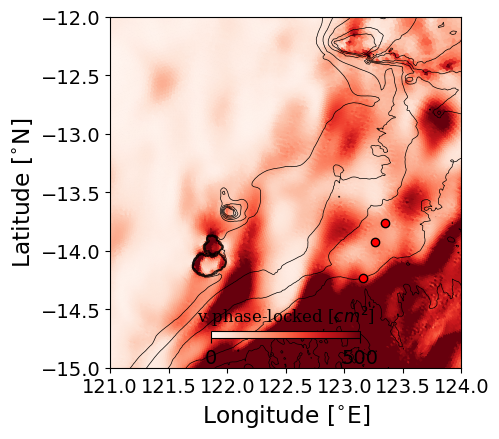

In [112]:
vmax = 0.05*1e4
xlim = 121,124
ylim = -15, -12
units='$cm^2$'
###

plt.figure()
ax1=plt.subplot(111, facecolor='0.5')
_,_,cc,_ = ds.suntans.plotcelldata(vc_pl_var*1e4, 
                                          cmap='Reds', vmin=0,vmax=vmax, colorbar=False)
plot_contours(ds, clevs=[100,200,300,400,500])
add_colorbar(ax1, cc, 0, vmax, r'v phase-locked [{}]'.format(units))
#plt.title('Incoherent f amplitude [{}]'.format(units))
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
#ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]')  

plot_site('Prelude', ax1)
plot_site('INPEX_buoy', ax1)
plot_site('NWSBRW', ax1)

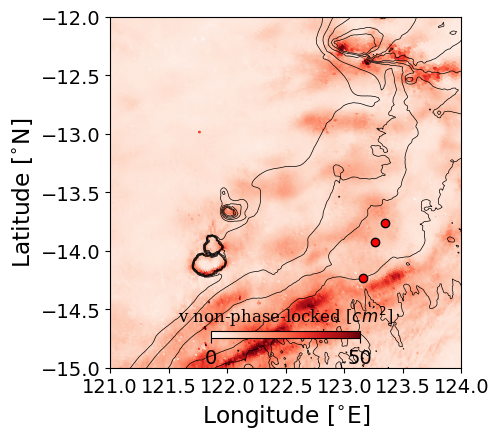

In [113]:
vmax = 0.005*1e4
xlim = 121,124
ylim = -15, -12
units='$cm^2$'

plt.figure()
ax1=plt.subplot(111, facecolor='0.5')
_,_,cc,_ = ds.suntans.plotcelldata(vc_npl_var*1e4, 
                                          cmap='Reds', vmin=0,vmax=vmax, colorbar=False)
plot_contours(ds, clevs=[100,200,300,400,500])
add_colorbar(ax1, cc, 0, vmax, r'v non-phase-locked [{}]'.format(units))
#plt.title('Incoherent f amplitude [{}]'.format(units))
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
#ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]')

plot_site('Prelude', ax1)
plot_site('INPEX_buoy', ax1)
plot_site('NWSBRW', ax1)

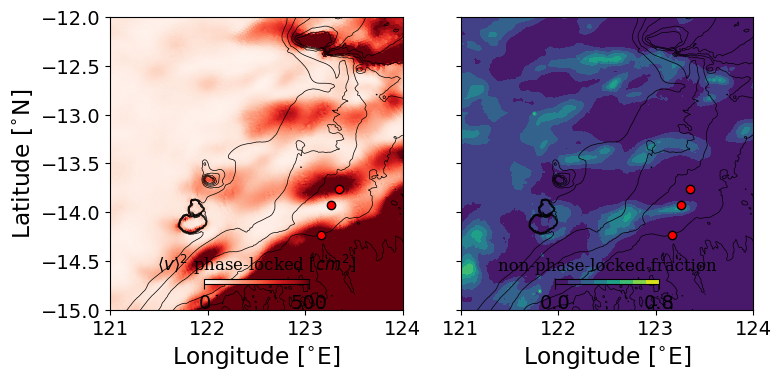

In [83]:
vmax = 0.05*1e4
xlim = 121,124
ylim = -15, -12
units='$cm^2$'


plt.figure(figsize=(9,4))

ax1=plt.subplot(121, facecolor='0.5')
_,_,cc,_ = ds.suntans.plotcelldata(vc_pl_var*1e4, 
                                          cmap='Reds', vmin=0,vmax=vmax, colorbar=False)
plot_contours(ds, clevs=[100,200,300,400,500])
add_colorbar(ax1, cc, 0, vmax, r'$\left<v\right>^2$ phase-locked [{}]'.format(units))
#plt.title('Incoherent f amplitude [{}]'.format(units))
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
#ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
plt.ylabel('Latitude [$^{\circ}$N]')  
plot_site('Prelude', ax1)
plot_site('INPEX_buoy', ax1)
plot_site('NWSBRW', ax1)

###
units = ''
vmin=0.0
vmax=0.8
ax2=plt.subplot(122, facecolor='0.5')
# _,_,cc,_ = ds.suntans.plotcelldata(ratio2, 
                                          # cmap='viridis', vmin=vmin,vmax=vmax, colorbar=False)
_,_,cc,_ = ds.suntans.contourf(ratio2, np.arange(0,vmax+0.1,0.1),
                                          cmap='viridis', vmin=vmin,vmax=vmax, colorbar=False)
plot_contours(ds, clevs=[100,200,300,400,500])
add_colorbar(ax2, cc, vmin, vmax, r'non-phase-locked fraction')
#plt.title('Incoherent f amplitude [{}]'.format(units))
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
#ax1.set_xticklabels([])
plt.xlabel('Longitude [$^{\circ}$E]')
ax2.set_yticklabels([])
#plt.tight_layout()
plt.subplots_adjust(wspace=0.01)

plot_site('Prelude', ax2)
plot_site('INPEX_buoy', ax2)
plot_site('NWSBRW', ax2)
# plt.ylabel('Latitude [$^{\circ}$N]')  
plt.savefig('../FIGURES/non_phase_locked_ratio_Browse.png',dpi=150)